In [228]:
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import sklearn
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
import latexify as lt
import os
#from thinkdsp import read_json
import scipy
import speechpy
#LOSO Validation
loo = LeaveOneOut()

In [229]:
import tsfel

In [230]:
#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

LR with advanced features (MFCC, Chroma and Melspectogram)

In [231]:
n95 = pd.read_csv("data_FVC_N95.csv")
print("Total Data Points = ",len(n95))
n95.head(7)

Total Data Points =  9


,Unnamed: 0,Filename,Name,rPEF,rFEV1,rFVC,rRatio,gPEF,gFEV1,gFVC,gRatio
0,0,Maithili01.FVC_N95.2b66lj8n.wav,Maithili01,2.84,0.19,3.56,5.337079,4.39,2.12,2.86,74.125874
1,1,Rahul01.FVC_C.2b8ki4jm.wav,Rahul01,1.99,0.10,1.74,5.747126,7.00,3.43,3.43,100.000000
2,2,Shikha.FVC_N95.2b6bnd0l.wav,Shikha,3.22,0.16,4.85,3.298969,4.50,1.92,2.07,92.753623
3,3,Vignesh.FVC_N95.2bb8mr8l.wav,Vignesh,2.44,0.16,3.37,4.747774,7.12,3.16,3.28,96.341463
4,4,Yash.FVC_N95.2b8n0616.wav,Yash,1.98,0.12,2.02,5.940594,7.81,2.96,2.96,100.000000
5,5,Sandra.FVC_N95.2bda6hnu.wav,Sandra,2.35,0.09,2.46,3.658537,4.07,2.59,2.67,97.003745
6,6,Hatim.FVC_N95.2be0uvo6.wav,Hatim,2.55,0.06,2.74,2.189781,2.52,0.61,2.73,22.344322


In [9]:
# to understand what is going on
wave = read_json(filepath="n95data/006_FVC_N95_1.json")
cfg = tsfel.get_features_by_domain()
X = np.array(tsfel.time_series_features_extractor(cfg, wave.ys))[0]

*** Feature extraction started ***
60


<ipython-input-9-888fa758f744>:4: UserWarning: Using default sampling frequency set in configuration file.
  X = np.array(tsfel.time_series_features_extractor(cfg, wave.ys))[0]


In [11]:
tsfel.time_series_features_extractor(cfg, wave.ys)

*** Feature extraction started ***
60


<ipython-input-11-8b2b537b2393>:1: UserWarning: Using default sampling frequency set in configuration file.
  tsfel.time_series_features_extractor(cfg, wave.ys)


,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,...,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate
0,0.000304,0.005818,0.007899,0.009028,0.01103,0.006307,0.003208,0.003545,0.002553,0.001732,...,0.0,8467.0,1416.0,1.901369,8499.0,56016.898919,-5.230845e-07,726.725264,1.435677,2541.0


In [232]:
def get_features(filepath):
    
    #use the below line if the data is in json
    #wave = read_json(filepath=filepath)
    
    #use the below line if the data is in wav
    ys, fs = librosa.load(filepath)
    ys = speechpy.processing.preemphasis(ys, cof=0.98)
    
    #staching frames
    frames = speechpy.processing.stack_frames(ys, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01, filter=lambda x: np.ones((x,)),zero_padding=True)

    '''
    *MFCC*
    We calculate the mean value for every single coefficient for MFCC. It means that for every audio file
    we have a vector of size 13 elements (For MFCC with 13 coefficients).
    
    *MelSpectogram*
    We calculate the mean value for every single mel band. It means that for every audio file
    we have a vector of size 128 elements (For 128 Mel bands).
    
    *Chromagram*
    12 Chroma Bins are produced by default. Similar to above, we  have a vector of size 12 for each audio file
    
    '''
    
    #filter audio segments first
    #cutoff_low = 3000 # desired cutoff frequency of the filter, Hz
    #cutoff_high = 5000
    #order = 15
    #ys = butter_bandpass_filter(ys,cutoff_low,cutoff_high,16000,order)
    
    #speechfy features begins
    #extracting power spectrum
    power_spectrum = np.mean(speechpy.processing.power_spectrum(frames, fft_points=512), axis=0)
    #print(power_spectrum.shape)
    
    mfcc = speechpy.feature.mfcc(ys, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,
             num_filters=40, fft_length=512, low_frequency=0, high_frequency=None)
    mfcc_cmvn = np.mean(speechpy.processing.cmvnw(mfcc,win_size=301,variance_normalization=True), axis=0)
    
    logenergy = speechpy.feature.lmfe(ys, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,
             num_filters=40, fft_length=512, low_frequency=0, high_frequency=None)
    #logenergy_feature_cube = np.mean(speechpy.feature.extract_derivative_feature(logenergy), axis=0)
    logenergy = np.mean(logenergy, axis=0)
    
    mfe = speechpy.feature.mfe(ys, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,
             num_filters=40, fft_length=512, low_frequency=0, high_frequency=None)
    mfe = np.mean(mfe[0],axis=0)
    
    
    #librosa feature begins
    #stat_features = np.array(tsfel.time_series_features_extractor(cfg, wave.ys))[0]
    mfc_coefficients = np.mean(librosa.feature.mfcc(y=ys, n_mfcc=13, sr=16000),axis=1)
    #print(mfc_coefficients.shape)
    
    S, phase = librosa.magphase(librosa.stft(ys))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(S=S, sr=fs), axis=1)
    
    melspectogram = np.mean(librosa.feature.melspectrogram(y=ys, sr=16000, n_mels=64, fmax=8000),axis=1)
    #print(melspectogram.shape)
    
    stft_spectrogram=np.abs(librosa.stft(ys))
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=16000),axis=1)
    #print(chromagram.shape)
    
    
    '''
    We now have a vector of size 13+128+12 = 153 in the feature matrix. Later, we also add the approximate
    value of respective
    lung parameter which changes the size of the vector to 154
    '''
    #feature_matrix_r = np.hstack((mfc_coefficients,melspectogram))
    #feature_matrix_r = np.hstack((melspectogram))
    feature_matrix_r = np.hstack((mfe, logenergy, mfcc_cmvn,power_spectrum,melspectogram,chromagram,spectral_rolloff))

    #feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
    
    #add the estimated param as a feature
    #feature_matrix = np.hstack((feature_matrix_r, FEV1values))
    return feature_matrix_r


def load_data(lungParam):
    '''
    feature: it is either 'FEV1', 'FVC' or 'PEF'
    '''
    #get the ground truth
    y=  np.array([i for i in n95['g'+lungParam]])
    
    #prepare to store a lot of features in X
    X=[]
    count = 0
    for file in n95['Filename']:
        features = get_features("SpiroMask-July2021/SmartMaskData/FVC/N95/"+file)
        #print("Size of features = ",features.shape)
        X.append(features)
        count += 1
    X =  np.array(X)
    
    
    #add the estiamted lung param as a feature
    estiamtedValues = np.atleast_2d(n95['r'+lungParam].to_numpy()).T
    X = np.hstack((X, estiamtedValues))
    # Return arrays to plug into sklearn's cross-validation algorithms
    return X, np.array(y)

In [233]:
#ML inits
regressor = RandomForestRegressor(n_estimators = 5000, random_state = 0)
#regressor = SVR(kernel = 'rbf', c=0.1)
#regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.5,max_depth = 50, alpha = 10, n_estimators = 50)
#regressor = Lasso(alpha = 0.01)
#regressor = Ridge(alpha=0.01)

In [234]:
print("****Running Regression on PEF****")
X, Y = load_data('PEF')
loo.get_n_splits(X)
mse=0
pe= [] 
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #for RF and SVR
    reg = regressor.fit(X_train, y_train)
    
    #reg = LinearRegression().fit(X_train, y_train)
    #print("Learned coef is = ",reg.coef_[0])
    #print("Learned intercept is = ",reg.intercept_)
    print("Predicted= ", reg.predict(X_test))
    print("True = ", y_test)
    #mse = mse+mean_squared_error(reg.predict(X_test), y_test)
    pe.append(np.abs((y_test-reg.predict(X_test))/y_test))
print("PE Mean = ", np.mean(pe));
print("PE STD = ", np.std(pe))

print("\n\n****Running Regression on FEV1****")
X, Y = load_data('FEV1')
loo.get_n_splits(X)
mse=0
pe= [] 
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #for RF and SVR
    reg = regressor.fit(X_train, y_train)
    
    #reg = LinearRegression().fit(X_train, y_train)
    #print("Learned coef is = ",reg.coef_[0])
    #print("Learned intercept is = ",reg.intercept_)
    print("Predicted= ", reg.predict(X_test))
    print("True = ", y_test)
    #mse = mse+mean_squared_error(reg.predict(X_test), y_test)
    pe.append(np.abs((y_test-reg.predict(X_test))/y_test))
print("PE Mean = ", np.mean(pe));
print("PE STD = ", np.std(pe))

print("\n\n****Running Regression on FVC****")
X, Y = load_data('FVC')
loo.get_n_splits(X)
mse=0
pe= [] 
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #for RF and SVR
    reg = regressor.fit(X_train, y_train)
    
    #reg = LinearRegression().fit(X_train, y_train)
    #print("Learned coef is = ",reg.coef_[0])
    #print("Learned intercept is = ",reg.intercept_)
    print("Predicted= ", reg.predict(X_test))
    print("True = ", y_test)
    #mse = mse+mean_squared_error(reg.predict(X_test), y_test)
    pe.append(np.abs((y_test-reg.predict(X_test))/y_test))
print("PE Mean = ", np.mean(pe));
print("PE STD = ", np.std(pe))

****Running Regression on PEF****
694 153107 441 220.0


AssertionError: Signal dimention should be of the format of (N,) but it is (694, 441) instead

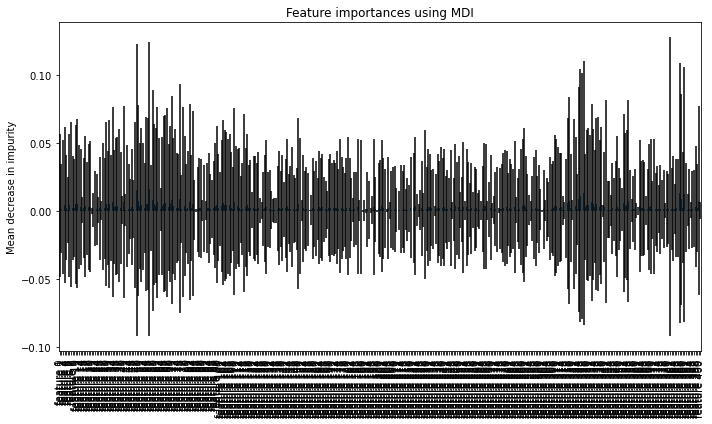

In [213]:
#plot important features for MFCC [0-12]
feature_names = [f'feature {i}' for i in range(X.shape[1])]
importances = regressor.feature_importances_

std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**It appears that MFCC Coeffieient Number 2, 4 and 6 are important**

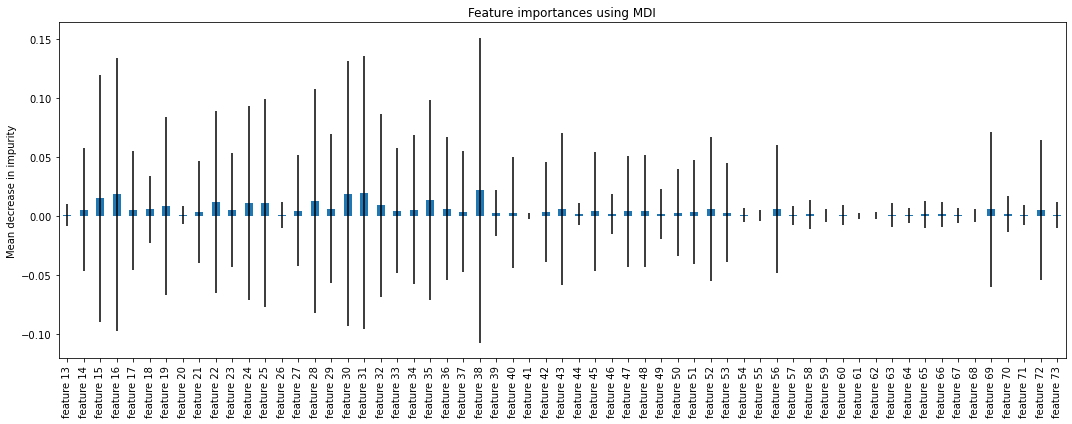

In [20]:
#plot important features for MelSpectogram [13-141]
feature_names = [f'feature {i}' for i in range(X.shape[1])]
importances = regressor.feature_importances_

std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

#realised that features beyond mel-band number 60 are anyway not important. Hence, we plot mel-band from 0 to 60
forest_importances = pd.Series(importances[13:74], index=feature_names[13:74])

fig, ax = plt.subplots(figsize=(15,6))
forest_importances.plot.bar(yerr=std[13:74], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=90)
fig.tight_layout()

**It appears that Mel band of 9, 30, 39 and 43 are important**

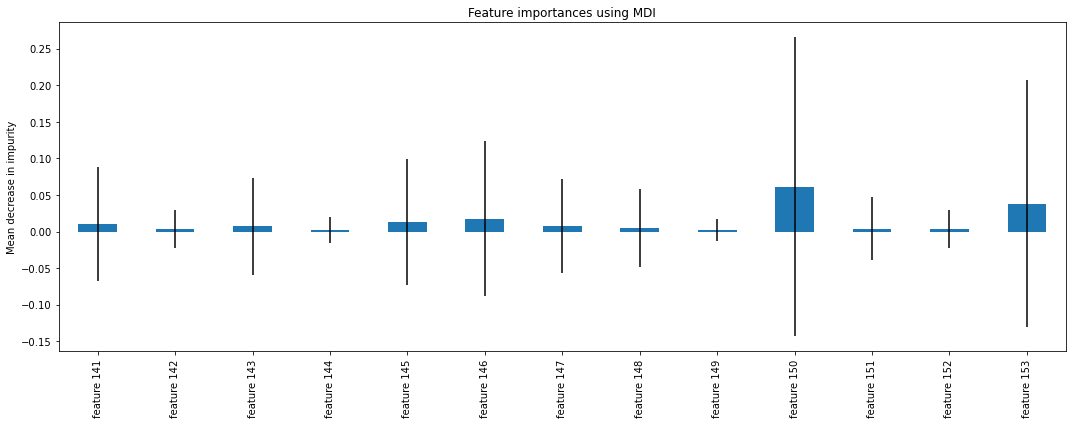

In [21]:
#plot important features for Chromagram  [151-154] (also includes the last feature which is approximate value of lung param)

feature_names = [f'feature {i}' for i in range(X.shape[1])]
importances = regressor.feature_importances_

std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

#realised that features beyond mel-band number 60 are anyway not important. Hence, we plot mel-band from 0 to 60
forest_importances = pd.Series(importances[141:154], index=feature_names[141:154])

fig, ax = plt.subplots(figsize=(15,6))
forest_importances.plot.bar(yerr=std[141:154], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=90)
fig.tight_layout()

**It appears Chromagram Coeffieient 5,10 and 13 are important**

Lets Plot the observed result

C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


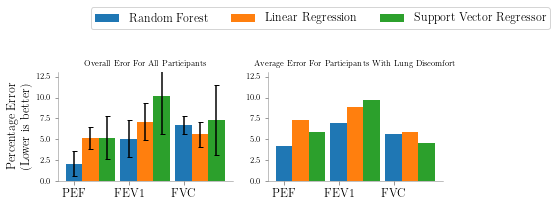

In [7]:
# plots to be manullly made using results from sheet
#N95 Mask

rf_pe= [2.1,5.1,6.7]
lr_pe = [5.2,7.1,5.6]
svr_pe = [5.2,10.2,7.3]

rf_std= [1.5,2.2,1.1]
lr_std = [1.3,2.2,1.5]
svr_std = [2.6,4.5,4.2]

rf_pe_u= [4.2,7,5.65]
lr_pe_u = [7.3,8.85,5.85]
svr_pe_u = [5.85,9.75,4.55]


figname = 'revised-overall-error-n95'
lt.latexify(columns=2, fig_height=2)
labels = ['PEF', 'FEV1', 'FVC']


x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(1,2)

rects1 = ax[0].bar(x, rf_pe, width, label='Random Forest', yerr=rf_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[0].bar(x + width, lr_pe, width, label='Linear Regression', yerr=lr_std, ecolor='black', capsize=2.5, align='center')
rects3 = ax[0].bar(x + width*2, svr_pe, width, label='Support Vector Regressor', yerr=svr_std, ecolor='black', capsize=2.5, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_title("Overall Eror For All Participants")
ax[0].set_ylabel('Percentage Error\n (Lower is better)',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize=12)
ax[0].set_ylim(0,13)
#ax[0].annotate(' Result For N95 Mask',xy=(0, 0), xytext=(60, 190),xycoords=('axes fraction', 'axes fraction'),textcoords='offset points',size=14, ha='center', va='bottom', weight='bold')
#ax[0].legend(bbox_to_anchor=[0.55,1.2],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[0])

rects1 = ax[1].bar(x, rf_pe_u, width, label='Random Forest', ecolor='black', capsize=2.5, align='center')
rects2 = ax[1].bar(x + width, lr_pe_u, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[1].bar(x + width*2, svr_pe_u, width, label='Support Vector Regressor', ecolor='black', capsize=2.5, align='center')
ax[1].set_title("Average Error For Participants With Lung Discomfort")
#ax[1].set_ylabel('Percentage Error',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize=12)
ax[1].set_ylim(0,13)
ax[1].legend(bbox_to_anchor=[0.3,1.5],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[1])




#fig.tight_layout()




plt.savefig(figname+'.pdf', bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


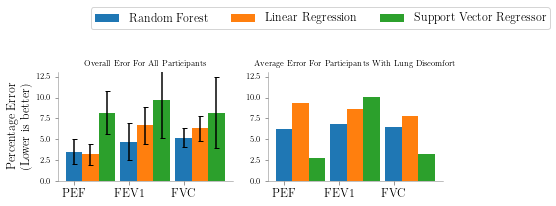

In [8]:
# plots to be manullly made using results from sheet
#Cloth Mask

rf_pe= [3.5,4.7,5.2]
lr_pe = [3.2,6.7,6.3]
svr_pe = [8.2,9.7,8.2]

rf_std= [1.5,2.2,1.1]
lr_std = [1.3,2.2,1.5]
svr_std = [2.6,4.5,4.2]

rf_pe_u= [6.2,6.8,6.5]
lr_pe_u = [9.3,8.6,7.8]
svr_pe_u = [2.8,10.1,3.21]


figname = 'revised-overall-error-cloth'
lt.latexify(columns=2, fig_height=2)
labels = ['PEF', 'FEV1', 'FVC']


x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(1,2)

rects1 = ax[0].bar(x, rf_pe, width, label='Random Forest', yerr=rf_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[0].bar(x + width, lr_pe, width, label='Linear Regression', yerr=lr_std, ecolor='black', capsize=2.5, align='center')
rects3 = ax[0].bar(x + width*2, svr_pe, width, label='Support Vector Regressor', yerr=svr_std, ecolor='black', capsize=2.5, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_title("Overall Eror For All Participants")
ax[0].set_ylabel('Percentage Error\n (Lower is better)',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize=12)
ax[0].set_ylim(0,13)
#ax[0].legend(bbox_to_anchor=[0.55,1.2],ncol=3, fontsize=12, loc='center')
#ax[0].annotate(' Result For Cloth Mask',xy=(0, 0), xytext=(60, 190),xycoords=('axes fraction', 'axes fraction'),textcoords='offset points',size=14, ha='center', va='bottom', weight='bold')
lt.format_axes(ax[0])

rects1 = ax[1].bar(x, rf_pe_u, width, label='Random Forest', ecolor='black', capsize=2.5, align='center')
rects2 = ax[1].bar(x + width, lr_pe_u, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[1].bar(x + width*2, svr_pe_u, width, label='Support Vector Regressor', ecolor='black', capsize=2.5, align='center')
ax[1].set_title("Average Error For Participants With Lung Discomfort")
#ax[1].set_ylabel('Percentage Error',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize=12)
ax[1].set_ylim(0,13)
ax[1].legend(bbox_to_anchor=[0.3,1.5],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[1])




#fig.tight_layout()




plt.savefig(figname+'.pdf', bbox_inches='tight')